In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from format_the_data import format_mi_band_data
from feature_engineering import get_wake_up_info_miband, get_wake_up_info_applewatch, get_heartrate_data_for_interval
from load_the_data import process_fitness_data
import json
from pprint import pprint
pd.options.mode.chained_assignment = None

In [2]:
### set os dir to data, same director but in folder data
os.chdir('data')
person1 = pd.read_csv('20231030_8210796956_MiFitness_hlth_center_fitness_data.csv')
person2 = pd.read_csv('20231030_8211531339_MiFitness_hlth_center_fitness_data.csv')
person3 = pd.read_csv('20231031_8210564343_MiFitness_hlth_center_fitness_data.csv')
person4 = pd.read_csv('20231110_8210586841_MiFitness_hlth_center_fitness_data.csv')

person1['Person ID'] = 1
person2['Person ID'] = 2
person3['Person ID'] = 3
person4['Person ID'] = 4

apple_sleep_data = pd.read_csv('sleep_apple.csv')
apple_heart_rate_data = pd.read_csv('heart_rate_apple.csv')

master_frame = pd.concat([person1, person2, person3, person4], ignore_index=True)

behaviour_tracking_data = pd.read_csv('Behavioural data app.csv')

In [4]:
unique_keys = ['pai',
               'valid_stand', 
               'calories',
               'steps',
               'heart_rate',
               'intensity',
               'dynamic',
               'single_heart_rate',
               'single_spo2',
               'training_load',
               'single_stress',
               'stress',
               'watch_night_sleep',
               'resting_heart_rate',
               'watch_daytime_sleep',
               'weight']
key_dataframes = format_mi_band_data(unique_keys, master_frame)


# separate dataframes:
pai_df = key_dataframes['pai']
valid_stand_df = key_dataframes['valid_stand']
calories_df = key_dataframes['calories']
steps_df = key_dataframes['steps']
heart_rate_df = key_dataframes['heart_rate']
intensity_df = key_dataframes['intensity']
dynamic_df = key_dataframes['dynamic']
single_heart_rate_df = key_dataframes['single_heart_rate']
single_spo2_df = key_dataframes['single_spo2']
training_load_df = key_dataframes['training_load']
single_stress_df = key_dataframes['single_stress']
stress_df = key_dataframes['stress']
watch_night_sleep_df = key_dataframes['watch_night_sleep']
resting_heart_rate_df = key_dataframes['resting_heart_rate']
watch_daytime_sleep_df = key_dataframes['watch_daytime_sleep']
weight_df = key_dataframes['weight']

In [16]:
aggregated_df = behaviour_tracking_data.copy()
aggregated_df['Date'] = pd.to_datetime(aggregated_df['Date created']).dt.date

# for apple watch
aggregated_df_person_5 = aggregated_df[aggregated_df['Person ID'] == 5]
aggregated_df_person_5 = get_wake_up_info_applewatch(apple_sleep_data, aggregated_df_person_5)

# for mi band
aggregated_df_rest = aggregated_df[aggregated_df['Person ID'] != 5]
aggregated_df_rest = get_wake_up_info_miband(watch_night_sleep_df, aggregated_df_rest)

# aggregate
aggregated_df = pd.concat([aggregated_df_person_5, aggregated_df_rest], ignore_index=True)

In [17]:
# Lets count the number of observations that are not linked to sleep data
total_obs = len(aggregated_df)
# filter out the rows where the time_of_awakening is NaN
aggregated_df = aggregated_df[~aggregated_df['time_of_awakening'].isna()].reset_index(drop=True)
remaining_obs = len(aggregated_df)
print(f'Of the {total_obs} number of observations, we removed {total_obs - remaining_obs} due to missing sleep data.')

Of the 119 number of observations, we removed 8 due to missing sleep data.


In [21]:
# Only keep the relevant columns of heart rate data
heart_rate_df = heart_rate_df[['Person ID', 'Time', 'bpm']]

# Prepare apple_heart_rate_data for merging
apple_data_prepared = apple_heart_rate_data[['creationDate', 'value']].copy()
apple_data_prepared.rename(columns={'value': 'bpm'}, inplace=True)
apple_data_prepared['Person ID'] = 5

# Convert 'creationDate' to Unix epoch time (seconds since epoch)
apple_data_prepared['creationDate'] = pd.to_datetime(apple_data_prepared['creationDate'])
apple_data_prepared['Time'] = apple_data_prepared['creationDate'].astype('int64') // 10**9

# Drop the original 'creationDate' column
apple_data_prepared.drop('creationDate', axis=1, inplace=True)

# Use concat instead of append
heart_rate_df = pd.concat([heart_rate_df, apple_data_prepared], ignore_index=True)

In [25]:
def make_timeserie_graphs():

    time_interval = 60

    # Group the data by Person ID
    grouped_data = aggregated_df.groupby('Person ID')

    for person_id, person_data in grouped_data:
        plt.figure(figsize=(12, 7))

        smart_alarm_data_list = []
        no_smart_alarm_data_list = []

        for _, row in person_data.iterrows():
            temp_df = get_heartrate_data_for_interval(heart_rate_df, row['Person ID'], row['Date'], row['time_of_awakening'], time_interval)
            temp_df['Relative Time to Awakening (min)'] = temp_df['Relative Time to Awakening(s)'] / 60

            if row['Smart alarm']:
                smart_alarm_data_list.append(temp_df)
            else:
                no_smart_alarm_data_list.append(temp_df)

            # Plot each morning data
            color = 'green' if row['Smart alarm'] else 'red'
            plt.plot(temp_df['Relative Time to Awakening (min)'], temp_df['bpm'], color=color, alpha=0.3)

            # Highlight lowest three observations
            lowest_three = temp_df.nsmallest(3, 'bpm')
            plt.scatter(lowest_three['Relative Time to Awakening (min)'], lowest_three['bpm'], color='orange', edgecolor='black', zorder=5)

        # Plot average lines
        if smart_alarm_data_list:
            smart_alarm_data = pd.concat(smart_alarm_data_list)
            avg_smart_alarm = smart_alarm_data.groupby('Relative Time to Awakening (min)')['bpm'].mean()
            #plt.plot(avg_smart_alarm.index, avg_smart_alarm.values, linestyle='--', color='darkgreen', label='Avg with Smart Alarm', linewidth=2)

        if no_smart_alarm_data_list:
            no_smart_alarm_data = pd.concat(no_smart_alarm_data_list)
            avg_no_smart_alarm = no_smart_alarm_data.groupby('Relative Time to Awakening (min)')['bpm'].mean()
            #plt.plot(avg_no_smart_alarm.index, avg_no_smart_alarm.values, linestyle='--', color='darkred', label='Avg without Smart Alarm', linewidth=2)

        # Add trend line for smart alarm data
        if smart_alarm_data_list:
            smart_alarm_data = pd.concat(smart_alarm_data_list)
            x = smart_alarm_data['Relative Time to Awakening (min)']
            y = smart_alarm_data['bpm']
            z = np.polyfit(x, y, 1)  # 1 for linear
            p = np.poly1d(z)
            plt.plot(x, p(x), color='darkgreen', label='Trendline Smart Alarm',linewidth=2)

        # Add trend line for no smart alarm data
        if no_smart_alarm_data_list:
            no_smart_alarm_data = pd.concat(no_smart_alarm_data_list)
            x = no_smart_alarm_data['Relative Time to Awakening (min)']
            y = no_smart_alarm_data['bpm']
            z = np.polyfit(x, y, 1)  # 1 for linear
            p = np.poly1d(z)
            plt.plot(x, p(x), color='darkred', label='Trendline Without Smart Alarm', linewidth=2)
        

        # Draw a horizontal line at 10 minutes
        plt.axvline(x=10, color='black', linestyle='--', linewidth=1)

        plt.xlabel('Minutes since Awakening')
        plt.ylabel('Heart Rate (bpm)')
        plt.title(f"Heart Rate Data for Person {person_id}")
        plt.grid(True)
        plt.legend(loc='upper right')
        plt.show()

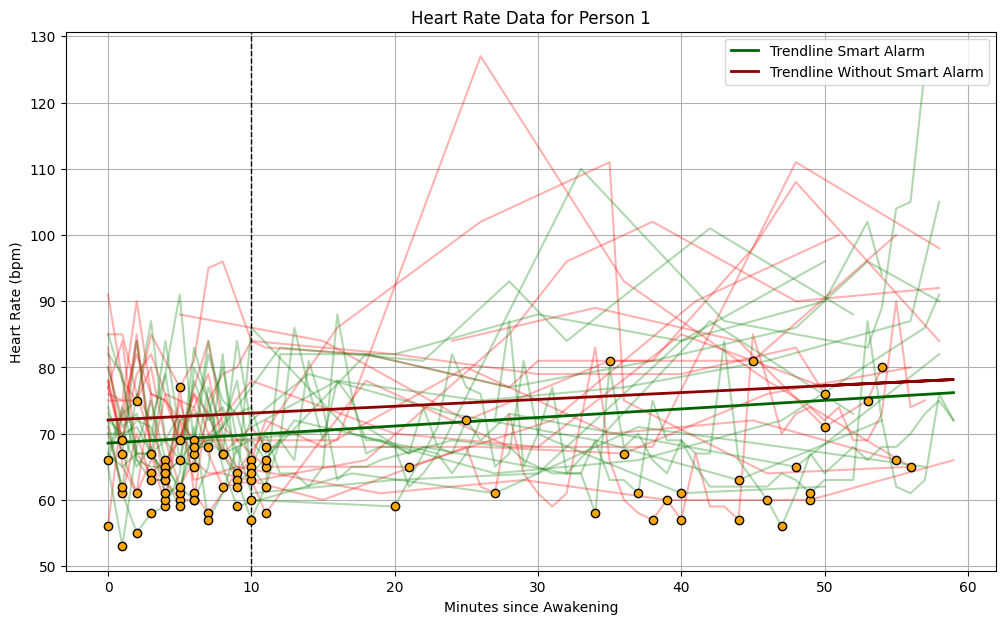

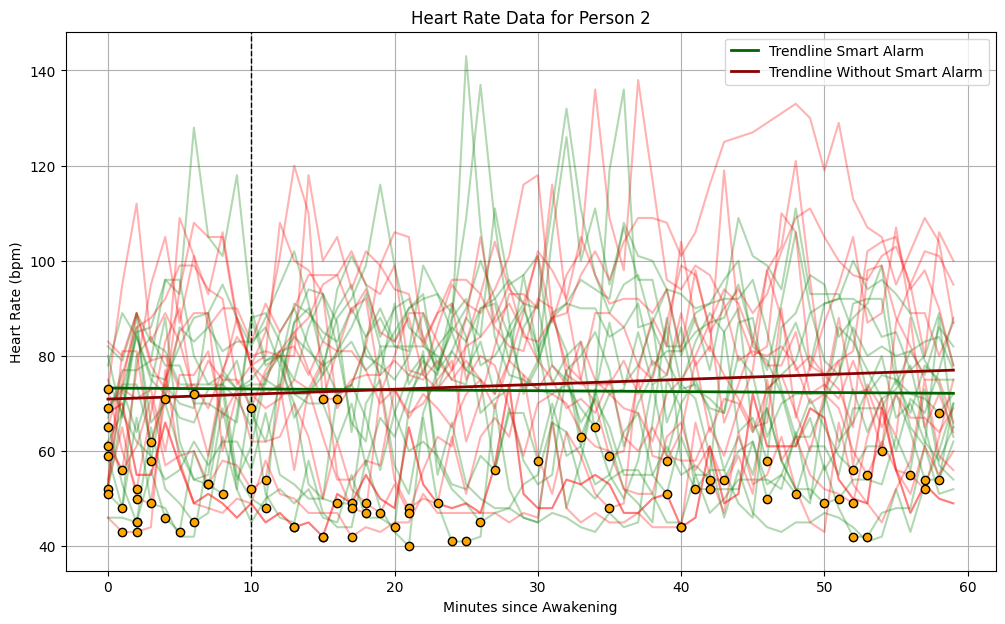

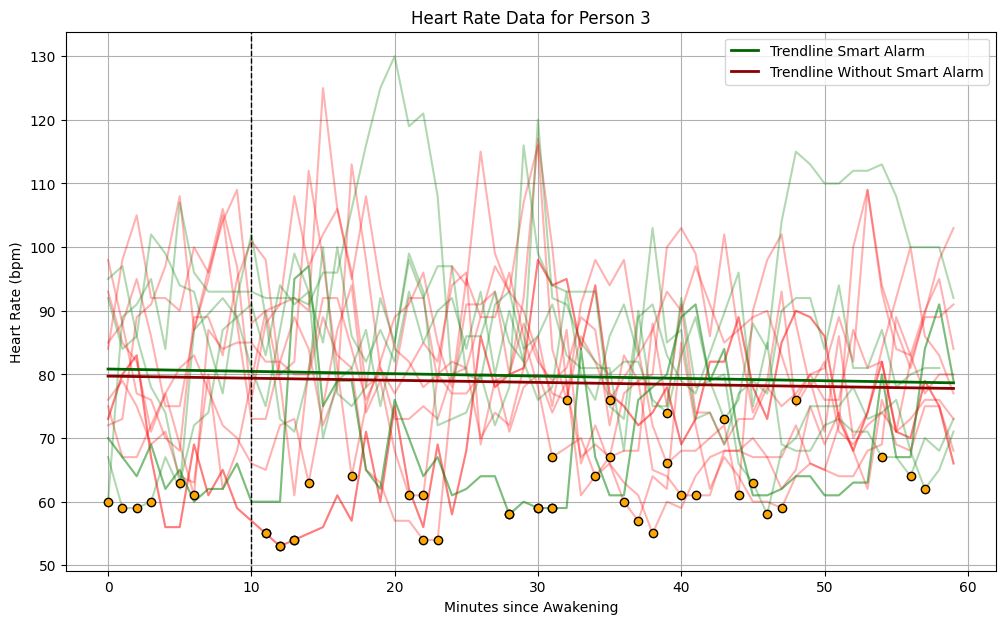

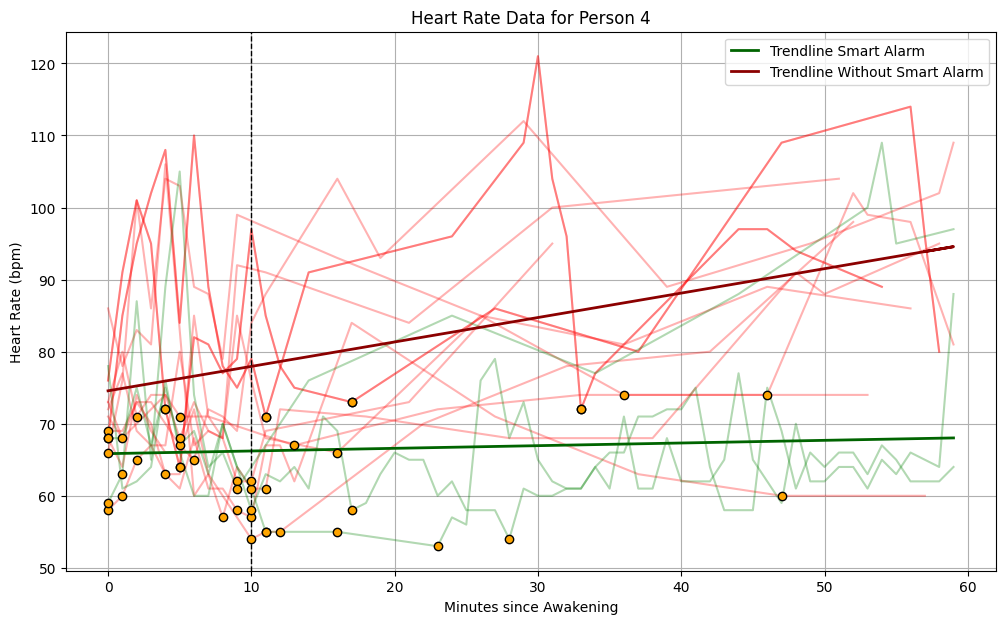

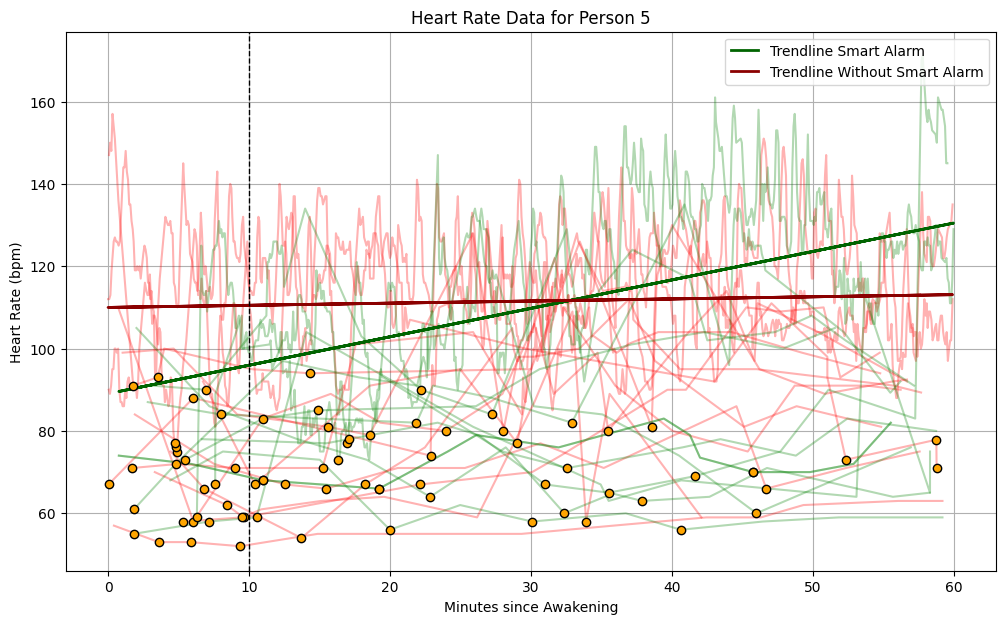

In [26]:
make_timeserie_graphs()

In [ ]:
watch_night_sleep_df[:2]

In [1]:
import seaborn as sns
# Assuming watch_night_sleep_df has 'Person ID' and 'duration' columns
# Filtering data for the first 4 persons
persons = [1, 2, 3, 4]
filtered_data = watch_night_sleep_df[watch_night_sleep_df['Person ID'].isin(persons)]

# Convert 'duration' from minutes to hours
filtered_data['duration'] = filtered_data['duration'] / 60

# Creating a boxplot for duration per person
plt.figure(figsize=(10, 6))
sns.boxplot(x='Person ID', y='duration', data=filtered_data, palette=['#D3D3D3', '#4B9F94'])

# Adding labels and title
plt.xlabel('Person ID')
plt.ylabel('Duration (Hours)')
plt.title('Duration Distribution per Person')

# Show the plot
plt.show()

NameError: name 'watch_night_sleep_df' is not defined

In [ ]:
# Filtering data for the first 4 persons
persons = [1, 2, 3, 4]
filtered_data = watch_night_sleep_df[watch_night_sleep_df['Person ID'].isin(persons)]

# Calculate the average duration for each sleep state per person
avg_durations = filtered_data.groupby('Person ID')[['sleep_deep_duration', 'sleep_light_duration', 'sleep_rem_duration', 'sleep_awake_duration']].mean()

# Reshaping the DataFrame for easier plotting
avg_durations = avg_durations.reset_index().melt(id_vars='Person ID', var_name='Sleep State', value_name='Average Duration')

# Creating a grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Person ID', y='Average Duration', hue='Sleep State', data=avg_durations, palette=['#424c4eff', '#d3d3d3ff', '#4b9f94ff', '#ba5745ff'])

# Adding labels and title
plt.xlabel('Person ID')
plt.ylabel('Average Duration (Minutes)')
plt.title('Average Duration per Sleep State for Each Person')

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filtering data for the first 4 persons
persons = [1, 2, 3, 4]
filtered_data = watch_night_sleep_df[watch_night_sleep_df['Person ID'].isin(persons)]

# Use 'duration' column for total sleep duration per person
total_duration = filtered_data.groupby('Person ID')['duration'].sum()

# Calculate the average percentage duration for each sleep state per person
avg_percentage_durations = filtered_data.groupby('Person ID')[['sleep_deep_duration', 'sleep_light_duration', 'sleep_rem_duration', 'sleep_awake_duration']].sum().div(total_duration, axis=0) * 100
avg_durations = filtered_data.groupby('Person ID')[['sleep_deep_duration', 'sleep_light_duration', 'sleep_rem_duration', 'sleep_awake_duration']].mean()

# Convert average duration to '2h 13m' format
def format_duration(minutes):
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    return f'{hours}h {mins}m'

avg_duration_formatted = avg_durations.applymap(format_duration)

# Creating a grid of horizontal bar charts
fig, axs = plt.subplots(1, 5, figsize=(25, 6), sharey=True)
sleep_states = ['sleep_deep_duration', 'sleep_light_duration', 'sleep_rem_duration', 'sleep_awake_duration']
colors = ['#424c4eff', '#d3d3d3ff', '#4b9f94ff', '#ba5745ff']

# Plot individual sleep states
for i, state in enumerate(sleep_states):
    sns.barplot(x=avg_percentage_durations[state], y=avg_percentage_durations.index, orient='h', ax=axs[i], color=colors[i])
    axs[i].set_title(f'{state.replace("_", " ").capitalize()}')
    axs[i].set_xlabel('Average Duration (%)')
    axs[i].set_ylabel('Person ID' if i == 0 else '')
    # Adding the formatted duration labels on the bars
    for index, value in enumerate(avg_percentage_durations[state]):
        axs[i].text(value, index, avg_duration_formatted.at[index + 1, state], va='center', ha='right')

# Plot combined 100% chart
avg_percentage_durations.plot(kind='barh', stacked=True, ax=axs[4], color=colors)
axs[4].set_title('Combined Sleep States')
axs[4].set_xlabel('Average Duration (%)')

# Adding green lines for desired intervals
desired_intervals = {'sleep_deep_duration': (10, 20), 'sleep_light_duration': (20, 60), 'sleep_rem_duration': (10, 30)}
for i, state in enumerate(sleep_states[:-1]): # Awake state is not applicable
    axs[i].axvline(desired_intervals[state][0], color='green', linestyle='--')
    axs[i].axvline(desired_intervals[state][1], color='green', linestyle='--')

# Adjusting layout
plt.tight_layout()
plt.show()
